In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge_2

Mounted at /gdrive
/gdrive/My Drive/Challenge_2


In [2]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

plt.rc("font", size=16)
from sklearn.preprocessing import MinMaxScaler

2.15.0


In [121]:
WINDOW_SIZE = 100
STRIDE = 5
TELESCOPE = 18

In [122]:
# 48000 time series of length 2776
dataset = np.load('training_data.npy', allow_pickle=True)
print(dataset.shape)


# containing for each of the time series the start and end index of the current series, i.e. the part without padding
valid_periods = np.load('valid_periods.npy', allow_pickle=True)
print(valid_periods.shape)


categories = np.load('categories.npy', allow_pickle=True)
print(categories.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [123]:
def createNewDatasetByCategory(dataset, categories, category, validPeriods):
  newDataset = []
  newValidPeriods = []
  idxs = [i for i, x in enumerate(categories) if x == category]
  for idx in idxs:
    newDataset.append(dataset[idx])
    newValidPeriods.append(validPeriods[idx])
  return newDataset, newValidPeriods

In [124]:
dataset_A, valid_periods_A = createNewDatasetByCategory(dataset , categories, 'C', valid_periods)
print(valid_periods_A[0])

[2345 2776]


In [125]:
# Extract the non zero part of the time series
def extract_current_serie(time_serie, valid_period):
  start = valid_period[0]
  end = valid_period[1]
  return time_serie[start:end]

In [126]:
# Transformer la série en un dataFrame d'une colonne
def create_column_dataframe(time_serie):
  transposed_array = np.transpose(time_serie)
  return pd.DataFrame(transposed_array)

In [127]:
def build_sequences(df, target_labels, window=100, stride=20, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_check = len(df)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [128]:
# Create 3 dim  array
X = np.empty((0, WINDOW_SIZE, 1))
y = np.empty((0, TELESCOPE, 1))

for i in range(0, len(dataset_A)):
  # while len(X) < 10000:
  current_serie = extract_current_serie(dataset_A[i], valid_periods_A[i])
  df = create_column_dataframe(current_serie)
  sequence, label = build_sequences(df, df.columns, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
  if sequence.ndim != X.ndim:
    continue
  X = np.concatenate((X, sequence), axis=0)
  y = np.concatenate((y, label), axis=0)
  if len(X) > 20000:
    print("Used", i, "time series.")
    break

print(X.shape, y.shape)

Used 295 time series.
(20019, 100, 1) (20019, 18, 1)


In [129]:
# Take a random 80% of the raws in X for training and 20% for testing
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_test = X[int(0.8 * len(X)):]
y_test = y[int(0.8 * len(y)):]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16015, 100, 1) (16015, 18, 1) (4004, 100, 1) (4004, 18, 1)


In [130]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [131]:
input_shape

(100, 1)

In [132]:
output_shape

(18, 1)

In [ ]:
def build_simple_LSTM_32(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # LSTM layer that returns only the last output in the sequence
    lstm_layer = tfkl.LSTM(units=32, return_sequences=False, input_shape=(100, 1))(
        input_layer
    )

    # Dense layer to transform the LSTM output to the desired shape
    dense_output = tfkl.Dense(18, name="dense")(
        lstm_layer
    )

    # Reshaping the output to match the desired output shape
    output_layer = tfkl.Reshape(output_shape, name="output_layer")(dense_output)

    # Creating the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="simple_LSTM")

    # Compile the model with Mean Squared Error Loss and the Adam Optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

In [ ]:
def build_simple_LSTM_64(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # LSTM layer that returns only the last output in the sequence
    lstm_layer = tfkl.LSTM(units=64, return_sequences=False, input_shape=(100, 1))(
        input_layer
    )

    # Dense layer to transform the LSTM output to the desired shape
    dense_output = tfkl.Dense(18, name="dense")(lstm_layer)

    # Reshaping the output to match the desired output shape
    output_layer = tfkl.Reshape(output_shape, name="output_layer")(dense_output)

    # Creating the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="simple_LSTM")

    # Compile the model with Mean Squared Error Loss and the Adam Optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

In [ ]:
def build_simple_LSTM_CONV(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Convolutional layers
    x = tfkl.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(
        input_layer
    )
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)

    # LSTM layer
    # The input to LSTM is 3D (batch_size, time_steps, features)
    x = tfkl.LSTM(units=50)(x)

    # Flatten the output for the Dense layer
    x = tfkl.Flatten()(x)

    # Dense layer to produce the final output
    x = tfkl.Dense(output_shape[0] * output_shape[1])(x)

    # Reshape layer to match the desired output shape
    output_layer = tfkl.Reshape(output_shape)(x)

    # Creating the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="simple_LSTM")

    # Compile the model with Mean Squared Error Loss and the Adam Optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

In [ ]:
def build_advanced_LSTM(input_shape, output_shape):
    model = tf.keras.Sequential()

    # First Conv1D layer
    model.add(
        tfkl.Conv1D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=input_shape,
            padding="same",
        )
    )
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.ReLU())
    model.add(tfkl.MaxPooling1D(pool_size=2))

    # Second Conv1D layer
    model.add(
        tfkl.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")
    )
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.ReLU())
    model.add(tfkl.MaxPooling1D(pool_size=2))

    # LSTM layer
    model.add(tfkl.LSTM(100, return_sequences=False))

    # Dropout layer
    model.add(tfkl.Dropout(0.5))

    # Dense layer for output
    model.add(tfkl.Dense(units=output_shape[0] * output_shape[1]))

    # Reshape layer to match the desired output shape
    model.add(tfkl.Reshape(output_shape))

    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

In [ ]:
def build_lstm_cnn_forecasting_model(input_shape, output_shape):
    model = tf.keras.Sequential()

    # LSTM layer for capturing long-term dependencies
    model.add(tfkl.LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(tfkl.LSTM(50, return_sequences=True))

    # Conv1D layers for refining the features
    model.add(tfkl.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(
        tfkl.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")
    )
    model.add(tfkl.MaxPooling1D(pool_size=2))

    # Flatten the output for the Dense layer
    model.add(tfkl.Flatten())

    # Dense layer to produce the final output
    model.add(tfkl.Dense(units=output_shape[0] * output_shape[1]))

    # Reshape layer to match the desired output shape
    model.add(tfkl.Reshape(output_shape))

    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

In [ ]:
def build_advanced_lstm_cnn_bidirectional(input_shape, output_shape):
    model = tf.keras.Sequential()

    # Bidirectional LSTM layer
    model.add(
        tfkl.Bidirectional(
            tfkl.LSTM(64, return_sequences=True), input_shape=input_shape
        )
    )
    model.add(tfkl.BatchNormalization())

    # Conv1D layers for feature extraction
    model.add(
        tfkl.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")
    )
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(
        tfkl.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")
    )
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(tfkl.BatchNormalization())

    # Flatten the output for the Dense layer
    model.add(tfkl.Flatten())

    # Dense layers with Dropout for regularization
    model.add(tfkl.Dense(128, activation="relu"))
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Dense(64, activation="relu"))
    model.add(tfkl.Dropout(0.3))

    # Output layer
    model.add(tfkl.Dense(output_shape[0] * output_shape[1]))
    model.add(tfkl.Reshape(output_shape))

    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

In [ ]:
def build_advanced_model_with_attention_conv(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape)

    # Bidirectional LSTM
    lstm_out = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)

    # Conv1D layers
    conv_out = tfkl.Conv1D(
        filters=128, kernel_size=3, padding="same", activation="relu"
    )(lstm_out)
    conv_out = tfkl.GlobalMaxPooling1D()(conv_out)
    # Repeat the conv_out to match lstm_out shape
    repeated_conv_out = tfkl.RepeatVector(input_shape[0])(conv_out)

    # Concatenate LSTM output and repeated Conv output
    concatenated = tfkl.Concatenate()([lstm_out, repeated_conv_out])

    # Attention layer
    attention_out = tfkl.Attention()([concatenated, concatenated])

    # Conv1D layers for matching the output shape
    conv_for_output = tfkl.Conv1D(
        filters=output_shape[1], kernel_size=1, activation="relu"
    )(attention_out)
    # Adjusting the sequence length to match the output shape
    if input_shape[0] != output_shape[0]:
        conv_for_output = tfkl.Conv1D(
            filters=output_shape[1],
            kernel_size=(input_shape[0] - output_shape[0] + 1),
            activation="relu",
        )(conv_for_output)

    # Flatten and Reshape to match exact output shape
    flatten_out = tfkl.Flatten()(conv_for_output)
    output_layer = tfkl.Dense(output_shape[0] * output_shape[1])(flatten_out)
    output_layer = tfkl.Reshape(output_shape)(output_layer)

    # Create and compile model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

In [ ]:
def build_transformer_time_series_model(
    input_shape, output_shape, num_heads, dff, maximum_position_encoding
):
    input_layer = tfkl.Input(shape=input_shape)

    # Positional Encoding
    pos_encoding = tfkl.Lambda(
        lambda x: positional_encoding(maximum_position_encoding, input_shape[-1])
    )(input_layer)
    x = tfkl.Add()([input_layer, pos_encoding])

    # Transformer Layer
    transformer_block = TransformerEncoder(num_heads, dff, input_shape[-1])
    x = transformer_block(x)

    # Conv1D layers can still be used for local feature extraction
    conv_out = tfkl.Conv1D(
        filters=128, kernel_size=3, padding="same", activation="relu"
    )(x)
    conv_out = tfkl.Conv1D(
        filters=128, kernel_size=3, padding="same", activation="relu"
    )(conv_out)

    # Flattening and Dense layers
    flatten_out = tfkl.Flatten()(conv_out)
    dense_out = tfkl.Dense(output_shape[0] * output_shape[1], activation="relu")(
        flatten_out
    )
    output_layer = tfkl.Reshape(output_shape)(dense_out)

    # Create and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model


# Transformer Encoder Layer
class TransformerEncoder(tfkl.Layer):
    def __init__(self, num_heads, dff, model_dim):
        super(TransformerEncoder, self).__init__()
        self.multi_head_attention = tfkl.MultiHeadAttention(
            num_heads=num_heads, key_dim=model_dim
        )
        self.ffn = tf.keras.Sequential(
            [tfkl.Dense(dff, activation="relu"), tfkl.Dense(model_dim)]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        attn_output = self.multi_head_attention(x, x, x)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


# Positional Encoding
def positional_encoding(position, d_model):
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model
    )
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [66]:
def build_CONV_LSTM_attention_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert (
        input_shape[0] >= output_shape[0]
    ), "For this exercise, we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units and return sequences
    lstm_out = tfkl.Bidirectional(
        tfkl.LSTM(64, return_sequences=True, name="lstm"), name="bidirectional_lstm"
    )(input_layer)

    # Add attention mechanism
    attention = tfkl.Attention()([lstm_out, lstm_out])

    # Concatenate attention output and LSTM output
    x = tfkl.Concatenate(axis=-1)([lstm_out, attention])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding="same", activation="relu", name="conv")(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding="same", name="output_layer")(
        x
    )

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name="cropping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(
        inputs=input_layer, outputs=output_layer, name="CONV_LSTM_attention_model"
    )

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model


In [67]:
def build_transformer_attention_model(input_shape, output_shape, num_heads=8, ff_dim=32, num_transformer_blocks=4, mlp_units=[128]):
    # Ensure the input time steps are at least as many as the output time steps
    assert (
        input_shape[0] >= output_shape[0]
    ), "For this exercise, we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units and return sequences
    lstm_out = tfkl.Bidirectional(
        tfkl.LSTM(64, return_sequences=True, name="lstm"), name="bidirectional_lstm"
    )(input_layer)

    # Add attention mechanism
    attention = tfkl.Attention()([lstm_out, lstm_out])

    # Concatenate attention output and LSTM output
    transformer_input = tfkl.Concatenate(axis=-1)([lstm_out, attention])

    # Transformer Encoder
    x = transformer_input
    for _ in range(num_transformer_blocks):
        x = _build_transformer_block(x, num_heads, ff_dim)

    # Global Average Pooling
    x = tfkl.GlobalAveragePooling1D()(x)

    # MLP Head
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)

    # Output layer for forecasting 18 values
    output_layer = tfkl.Dense(output_shape[0] * output_shape[1], activation="linear", name="output_layer")(x)

    # Reshape the output to the desired shape (18, 1)
    output_layer = tfkl.Reshape(target_shape=output_shape, name="reshaping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(
        inputs=input_layer, outputs=output_layer, name="TransformerAttentionModel"
    )

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

def _build_transformer_block(x, num_heads, ff_dim):
    # Ensure num_heads is less than x.shape[-1]
    num_heads = min(num_heads, x.shape[-1])

    # Calculate key_dim based on input shape
    key_dim = x.shape[-1] // num_heads if x.shape[-1] is not None else None

    # Multi-Head Attention
    attn_layer = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        x, x, x
    )
    attn_output = tfkl.Add()([x, attn_layer])
    attn_output = tfkl.LayerNormalization(epsilon=1e-6)(attn_output)

    # Feed Forward Part
    ffn = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attn_output)
    ffn = tfkl.Conv1D(filters=x.shape[-1], kernel_size=1)(ffn)
    x = tfkl.Add()([attn_output, ffn])
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)

    return x


In [68]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert (
        input_shape[0] >= output_shape[0]
    ), "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(
        tfkl.LSTM(32, return_sequences=True, name="lstm"), name="bidirectional_lstm"
    )(input_layer)

    # Add a 1D Convolution layer with 64 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding="same", activation="relu", name="conv")(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding="same", name="output_layer")(
        x
    )

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name="cropping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(
        inputs=input_layer, outputs=output_layer, name="CONV_LSTM_model"
    )

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

In [ ]:
model1 = build_simple_LSTM_32(input_shape, output_shape)
# model1.summary()
# tfk.utils.plot_model(model1, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history1 = model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 5s 9ms/step - loss: 0.0368 - val_loss: 0.0168 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 1s 7ms/step - loss: 0.0171 - val_loss: 0.0162 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0166 - val_loss: 0.0160 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0165 - val_loss: 0.0157 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 2s 9ms/step - loss: 0.0162 - val_loss: 0.0156 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 2s 9ms/step - loss: 0.0160 - val_loss: 0.0154 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0157 - val_loss: 0.0152 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 0.0135 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 2s 7ms/step - loss: 0.0139 - val_

In [ ]:
model2 = build_simple_LSTM_64(input_shape, output_shape)
# model2.summary()
# tfk.utils.plot_model(model2, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history2 = model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 4s 9ms/step - loss: 0.0299 - val_loss: 0.0163 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 1s 7ms/step - loss: 0.0167 - val_loss: 0.0161 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 2s 7ms/step - loss: 0.0162 - val_loss: 0.0156 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0160 - val_loss: 0.0150 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 2s 9ms/step - loss: 0.0149 - val_loss: 0.0137 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 2s 9ms/step - loss: 0.0140 - val_loss: 0.0131 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0136 - val_loss: 0.0130 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0135 - val_loss: 0.0126 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 2s 7ms/step - loss: 0.0132 - val_

Model: "simple_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 64)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 50)                

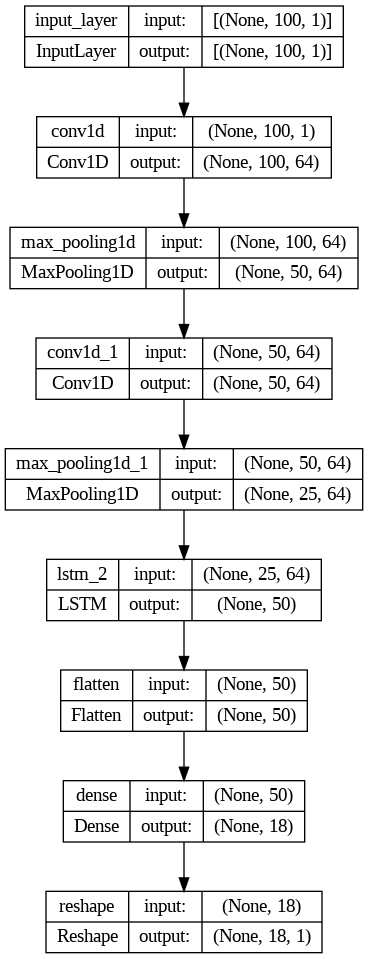

In [ ]:
model3 = build_simple_LSTM_CONV(input_shape, output_shape)
model3.summary()
tfk.utils.plot_model(model3, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history3 = model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 7s 9ms/step - loss: 0.0312 - val_loss: 0.0158 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0158 - val_loss: 0.0147 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0147 - val_loss: 0.0140 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 2s 7ms/step - loss: 0.0141 - val_loss: 0.0136 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0136 - val_loss: 0.0132 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0131 - val_loss: 0.0128 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 1s 6ms/step - loss: 0.0127 - val_loss: 0.0124 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0122 - val_loss: 0.0117 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0117 - val_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 100, 64)           256       
                                                                 
 batch_normalization (Batch  (None, 100, 64)           256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 100, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 50, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 128)           5

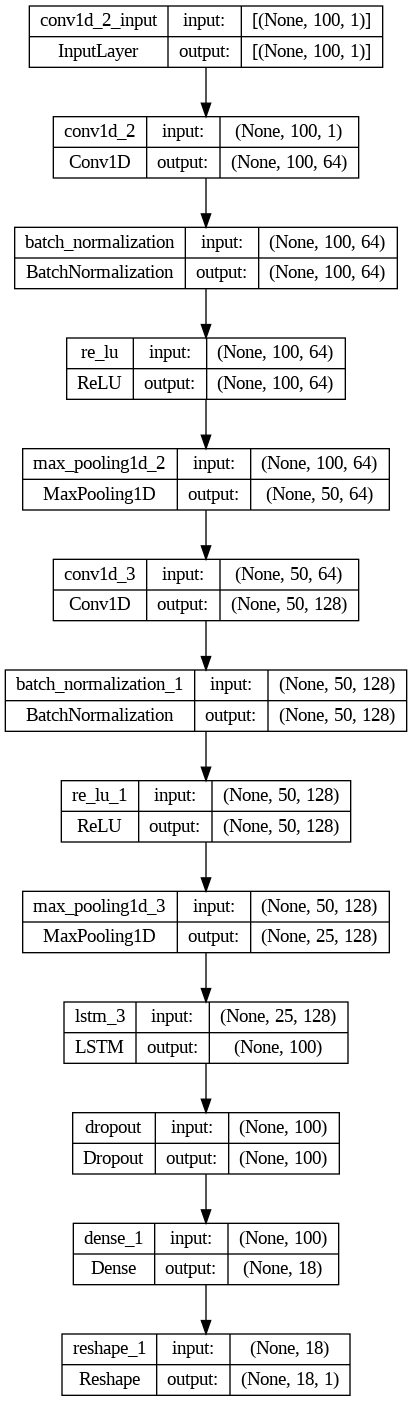

In [ ]:
model4 = build_advanced_LSTM(input_shape, output_shape)
model4.summary()
tfk.utils.plot_model(model4, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history4 = model4.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 7s 10ms/step - loss: 0.0481 - val_loss: 0.1755 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0230 - val_loss: 0.0715 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0196 - val_loss: 0.0154 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 2s 11ms/step - loss: 0.0179 - val_loss: 0.0131 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 3s 11ms/step - loss: 0.0164 - val_loss: 0.0126 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0155 - val_loss: 0.0120 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0147 - val_loss: 0.0121 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0141 - val_loss: 0.0113 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 2s 8ms/step - loss: 0.0134 - v

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_5 (LSTM)               (None, 100, 50)           20200     
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 64)           9664      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 50, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 25, 128)           0         
 g1D)                                                 

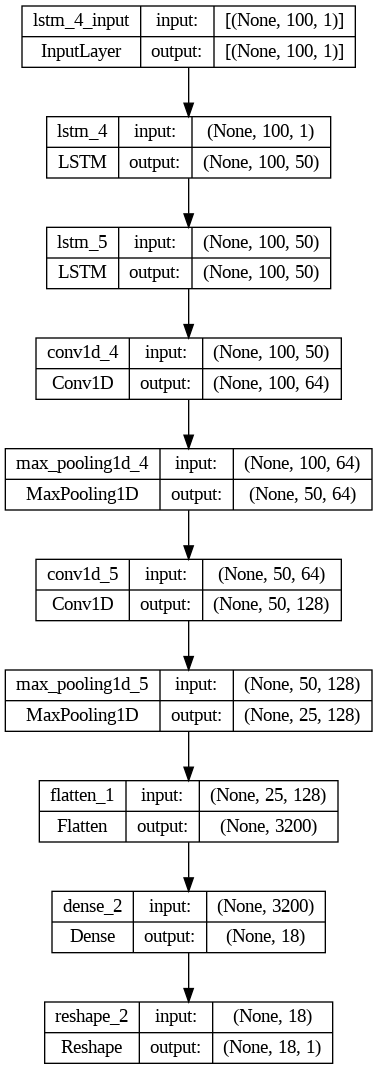

In [ ]:
model5 = build_lstm_cnn_forecasting_model(input_shape, output_shape)
model5.summary()
tfk.utils.plot_model(model5, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history5 = model5.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 9s 20ms/step - loss: 0.0294 - val_loss: 0.0146 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 3s 13ms/step - loss: 0.0142 - val_loss: 0.0132 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0129 - val_loss: 0.0129 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0123 - val_loss: 0.0121 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0117 - val_loss: 0.0112 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 4s 16ms/step - loss: 0.0117 - val_loss: 0.0111 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0112 - val_loss: 0.0115 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0108 - val_loss: 0.0107 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 3s 12ms/step - loss: 0.01

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100, 128)          33792     
 al)                                                             
                                                                 
 batch_normalization_2 (Bat  (None, 100, 128)          512       
 chNormalization)                                                
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 128)          49280     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 50, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 128)           49280     
                                                      

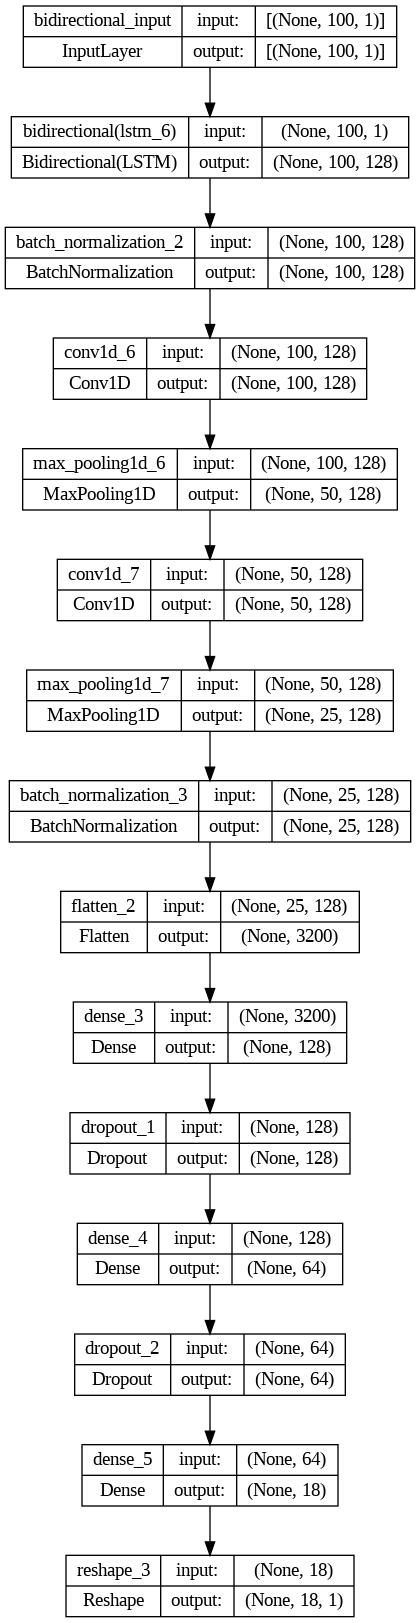

In [ ]:
model6 = build_advanced_lstm_cnn_bidirectional(input_shape, output_shape)
model6.summary()
tfk.utils.plot_model(model6, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history6 = model6.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 11s 19ms/step - loss: 0.0992 - val_loss: 0.6088 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0389 - val_loss: 0.0862 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 4s 19ms/step - loss: 0.0304 - val_loss: 0.0401 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 4s 16ms/step - loss: 0.0273 - val_loss: 0.0275 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0246 - val_loss: 0.0280 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0229 - val_loss: 0.0254 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 4s 17ms/step - loss: 0.0224 - val_loss: 0.0336 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 6s 25ms/step - loss: 0.0217 - val_loss: 0.0249 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 4s 19ms/step - loss: 0.0

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 100, 128)             33792     ['input_1[0][0]']             
 onal)                                                                                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 100, 128)             49280     ['bidirectional_1[0][0]']     
                                                                                                  
 global_max_pooling1d (Glob  (None, 128)                  0         ['conv1d_8[0][0]']        

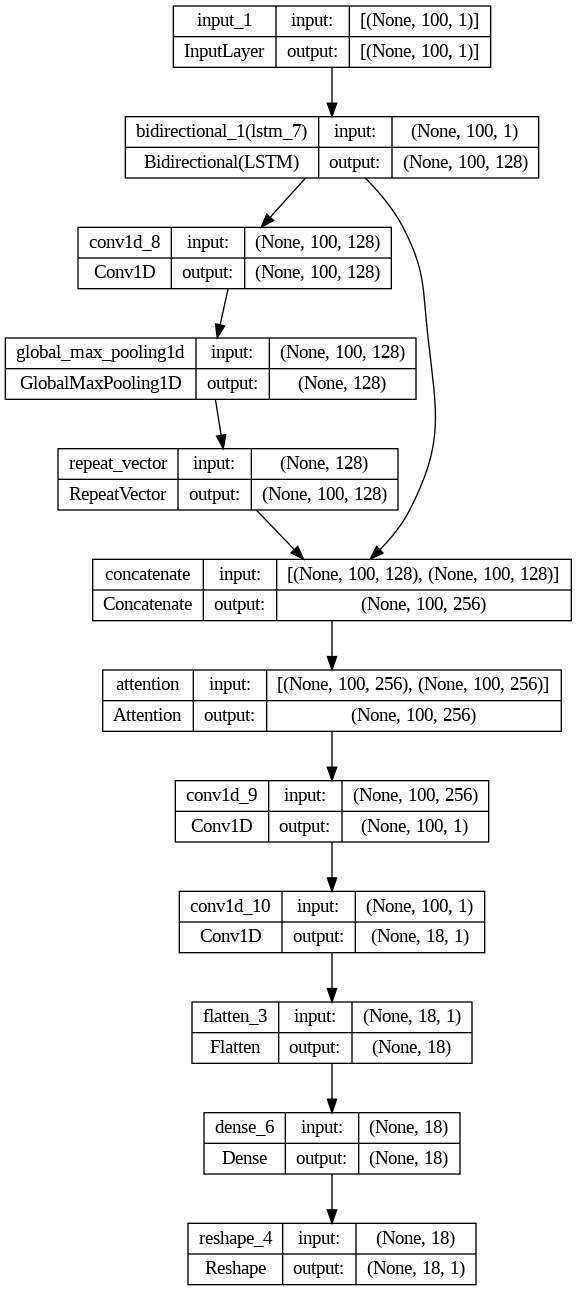

In [ ]:
model7 = build_advanced_model_with_attention_conv(input_shape, output_shape)
model7.summary()
tfk.utils.plot_model(model7, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history7 = model7.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 9s 17ms/step - loss: 0.2028 - val_loss: 0.1348 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 3s 13ms/step - loss: 0.1048 - val_loss: 0.0797 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 4s 18ms/step - loss: 0.0728 - val_loss: 0.0654 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 3s 13ms/step - loss: 0.0656 - val_loss: 0.0631 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0645 - val_loss: 0.0629 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0644 - val_loss: 0.0630 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 3s 13ms/step - loss: 0.0644 - val_loss: 0.0630 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 4s 17ms/step - loss: 0.0644 - val_loss: 0.0630 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 3s 13ms/step - loss: 0.06

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 lambda (Lambda)             (1, 100, 1)                  0         ['input_2[0][0]']             
                                                                                                  
 add (Add)                   (None, 100, 1)               0         ['input_2[0][0]',             
                                                                     'lambda[0][0]']              
                                                                                                  
 transformer_encoder (Trans  (None, 100, 1)               418       ['add[0][0]']           

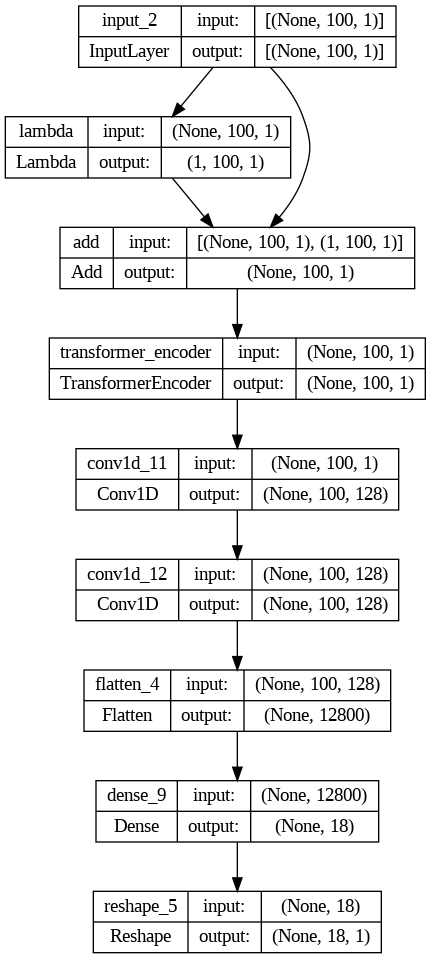

In [ ]:
# Transformer specific parameters
num_heads = 4  # Number of attention heads
dff = 128  # Depth of the feed-forward network
maximum_position_encoding = 100  # Maximum sequence length

# Building the model
model8 = build_transformer_time_series_model(
    input_shape, output_shape, num_heads, dff, maximum_position_encoding
)
model8.summary()
tfk.utils.plot_model(model8, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history8 = model8.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 5s 10ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 2s 8ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 2s 8ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 2s 11ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 3s 11ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 2s 8ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 2s 8ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 2s 8ms/step - loss: 0.2874 - val_loss: 0.2831 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 2s 8ms/step - loss: 0.2874 - v

Model: "CONV_LSTM_attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 100, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 100, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 attention_1 (Attention)     (None, 100, 128)             0         ['bidirectional_lstm[0][0]',  
                                                                     'bidirectional_lstm[0][0]']  
                                                                          

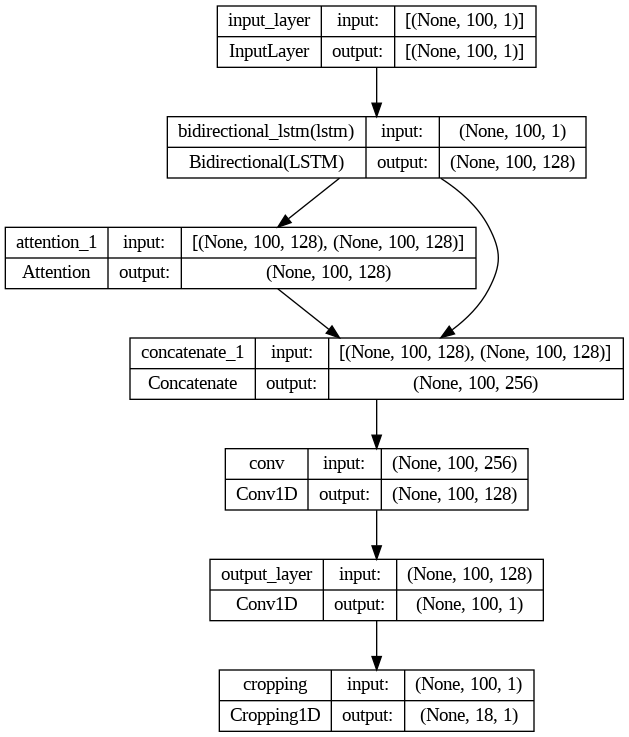

In [ ]:
model9 = build_CONV_LSTM_attention_model(input_shape, output_shape)
model9.summary()
tfk.utils.plot_model(model9, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history9 = model9.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 8s 17ms/step - loss: 0.0323 - val_loss: 0.0245 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 3s 15ms/step - loss: 0.0228 - val_loss: 0.0201 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0170 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0160 - val_loss: 0.0157 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0149 - val_loss: 0.0143 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0146 - val_loss: 0.0140 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 3s 15ms/step - loss: 0.0143 - val_loss: 0.0148 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 3s 15ms/step - loss: 0.0137 - val_loss: 0.0137 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 3s 12ms/step - loss: 0.01

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 100, 64)           8704      
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 100, 64)           12352     
                                                                 
 output_layer (Conv1D)       (None, 100, 1)            193       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 21249 (83.00 KB)
Trainable params: 21249 (83.00 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

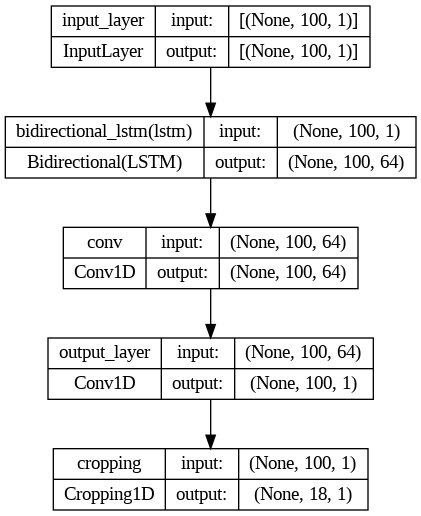

In [ ]:
model10 = build_CONV_LSTM_model(input_shape, output_shape)
model10.summary()
tfk.utils.plot_model(model10, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history10 = model10.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 8s 17ms/step - loss: 0.0482 - val_loss: 0.0336 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0278 - val_loss: 0.0289 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 3s 15ms/step - loss: 0.0250 - val_loss: 0.0232 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0229 - val_loss: 0.0221 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 2s 10ms/step - loss: 0.0209 - val_loss: 0.0185 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 2s 11ms/step - loss: 0.0210 - val_loss: 0.0179 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 2s 10ms/step - loss: 0.0193 - val_loss: 0.0159 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0185 - val_loss: 0.0164 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 3s 13ms/step - loss: 0.01

Model: "TransformerAttentionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 100, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 100, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 attention_2 (Attention)     (None, 100, 128)             0         ['bidirectional_lstm[0][0]',  
                                                                     'bidirectional_lstm[0][0]']  
                                                                          

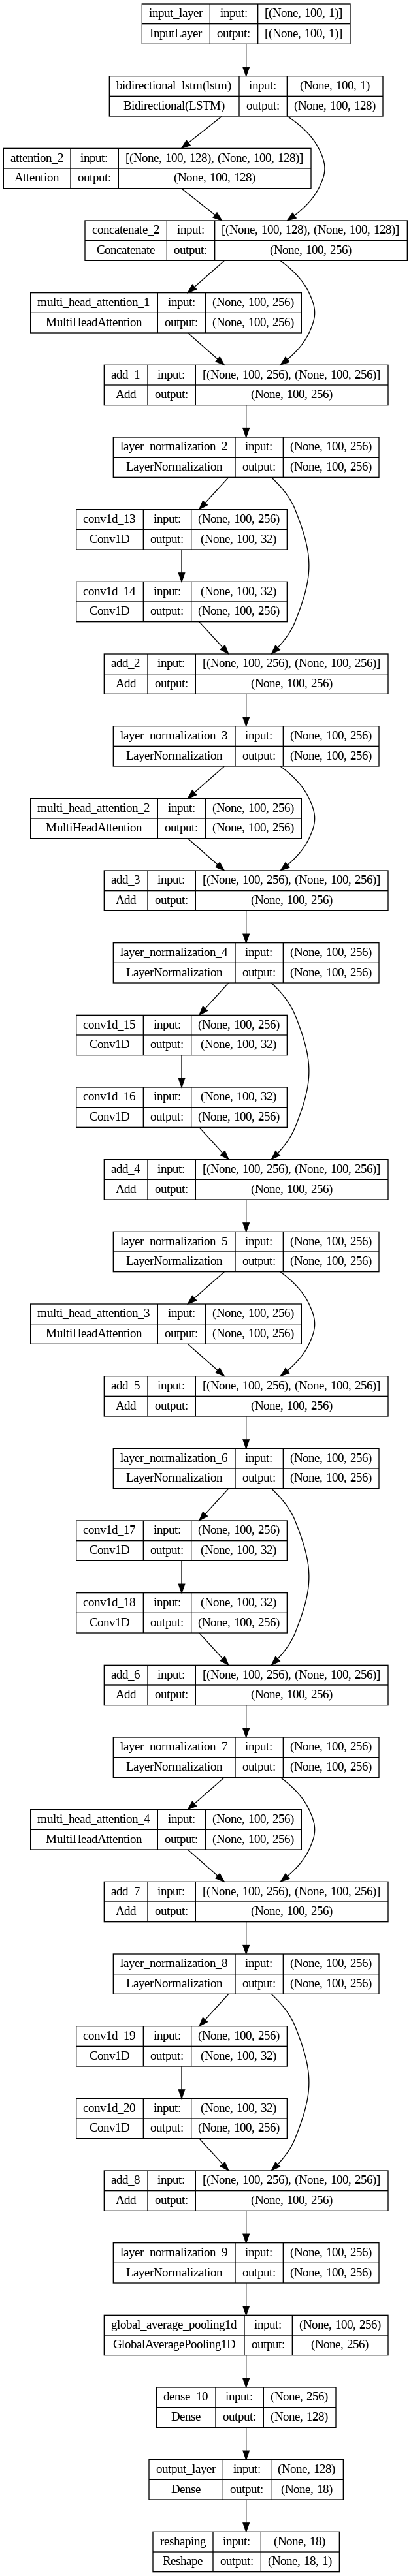

In [ ]:
model11 = build_transformer_attention_model(input_shape, output_shape)
model11.summary()
tfk.utils.plot_model(model11, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history11 = model11.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 29s 68ms/step - loss: 0.0465 - val_loss: 0.0230 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 14s 62ms/step - loss: 0.0176 - val_loss: 0.0190 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 14s 62ms/step - loss: 0.0170 - val_loss: 0.0166 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 14s 61ms/step - loss: 0.0163 - val_loss: 0.0159 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 14s 61ms/step - loss: 0.0153 - val_loss: 0.0153 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 14s 61ms/step - loss: 0.0151 - val_loss: 0.0137 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 14s 61ms/step - loss: 0.0141 - val_loss: 0.0135 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 14s 61ms/step - loss: 0.0137 - val_loss: 0.0129 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 14s 62ms/step - l

In [ ]:
def build_improved_LSTM_CONV(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Convolutional layers
    x = tfkl.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input_layer)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)

    # Bidirectional LSTM layer
    x = tfkl.Bidirectional(tfkl.LSTM(units=64))(x)

    # Flatten the output for the Dense layer
    x = tfkl.Flatten()(x)

    # Dense layer to produce the final output
    x = tfkl.Dense(output_shape[0] * output_shape[1])(x)

    # Reshape layer to match the desired output shape
    output_layer = tfkl.Reshape(output_shape)(x)

    # Creating the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="improved_LSTM_CONV")

    # Compile the model with Mean Squared Error Loss and the Adam Optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model


In [ ]:
model12 = build_improved_LSTM_CONV(input_shape, output_shape)
model12.summary()
tfk.utils.plot_model(model12, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history12 = model12.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

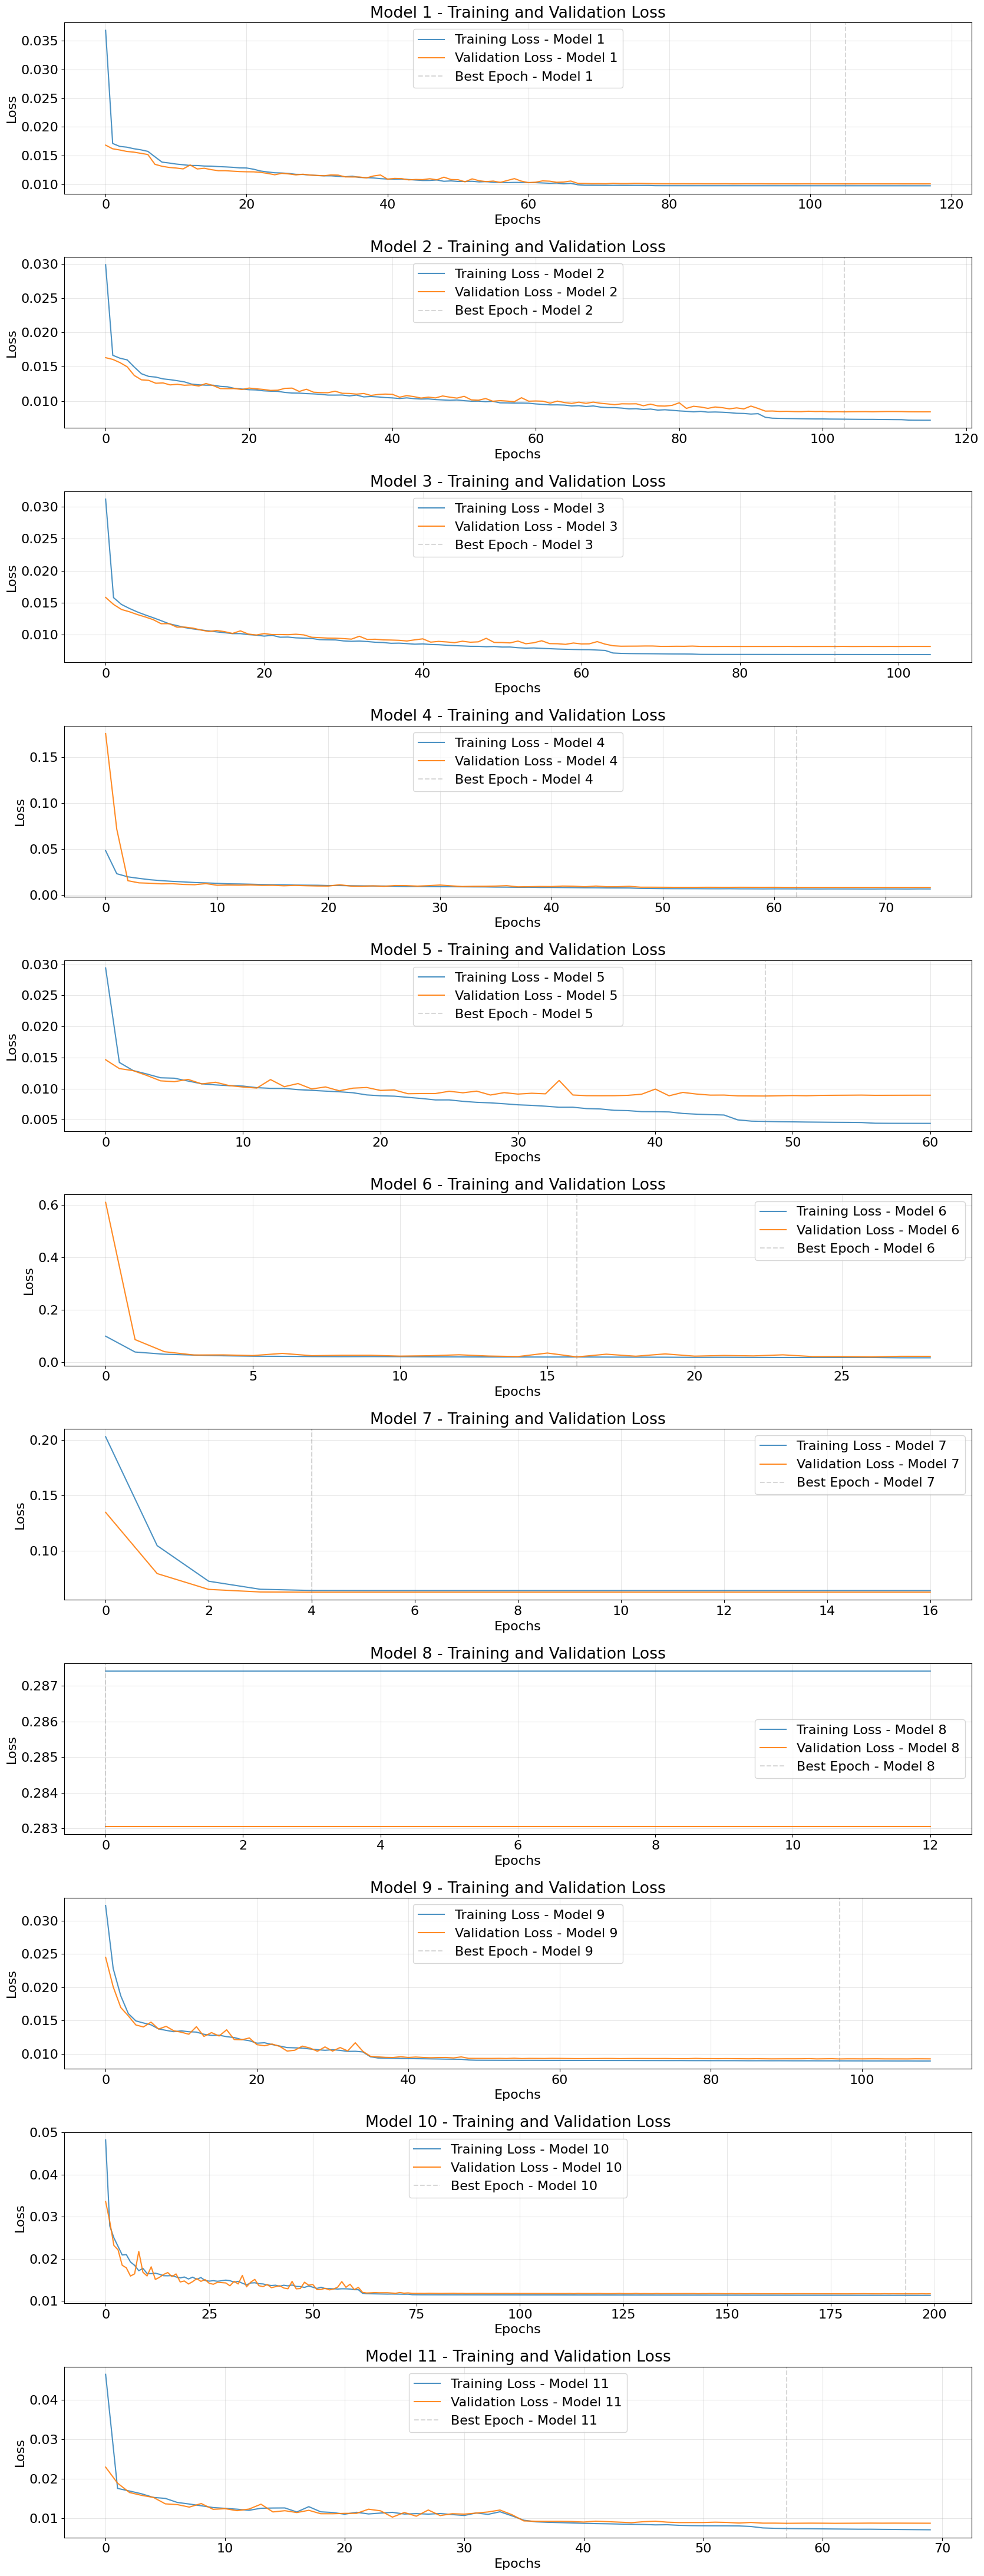

In [ ]:
import matplotlib.pyplot as plt

# Assuming history1 to history11 are your actual history objects
histories = [history1, history2, history3, history4, history5,
             history6, history7, history8, history9, history10, history11, history12]

# Number of models
num_models = len(histories)

# Create subplots - one for each model
fig, axes = plt.subplots(num_models, 1, figsize=(17, num_models * 4))

# Check if axes is iterable (needed for single subplot)
if num_models == 1:
    axes = [axes]

# Loop through each history object and plot the losses
for i, (ax, history) in enumerate(zip(axes, histories), start=1):
    best_epoch = np.argmin(history['val_loss'])
    ax.plot(history['loss'], label=f"Training Loss - Model {i}", alpha=0.8)
    ax.plot(history['val_loss'], label=f"Validation Loss - Model {i}", alpha=0.9)
    ax.axvline(x=best_epoch, label=f"Best Epoch - Model {i}", alpha=0.3, ls="--", color="grey")

    ax.set_title(f"Model {i} - Training and Validation Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [136]:
# Assuming X_test and y_test are your test set features and labels
# Replace model1 to model11 with your actual model variables

# Initialize lists to store the results
model_names = []
mse_values = []
mae_values = []

# Loop through each model and calculate errors
for i, model in enumerate(
    [
        model1,
        model2,
        model3,
        model4,
        model5,
        model6,
        model7,
        model8,
        model9,
        model10,
        model11,
        model12,
    ],
    start=1,
):
    # Predict the test set using the model
    predictions = model.predict(X_test, verbose=0)

    # Calculate Mean Squared Error (MSE)
    mse = tfk.metrics.mean_squared_error(
        y_test.flatten(), predictions.flatten()
    ).numpy()

    # Calculate Mean Absolute Error (MAE)
    mae = tfk.metrics.mean_absolute_error(
        y_test.flatten(), predictions.flatten()
    ).numpy()

    # Append results to the lists
    model_names.append(f"Model {i}")
    mse_values.append(mse)
    mae_values.append(mae)

# Create a DataFrame to display results in a table
results_df = pd.DataFrame({"Model": model_names, "MSE": mse_values, "MAE": mae_values})

# Display the DataFrame
print(results_df)

     Model       MSE       MAE
0  Model 1  0.006679  0.054481


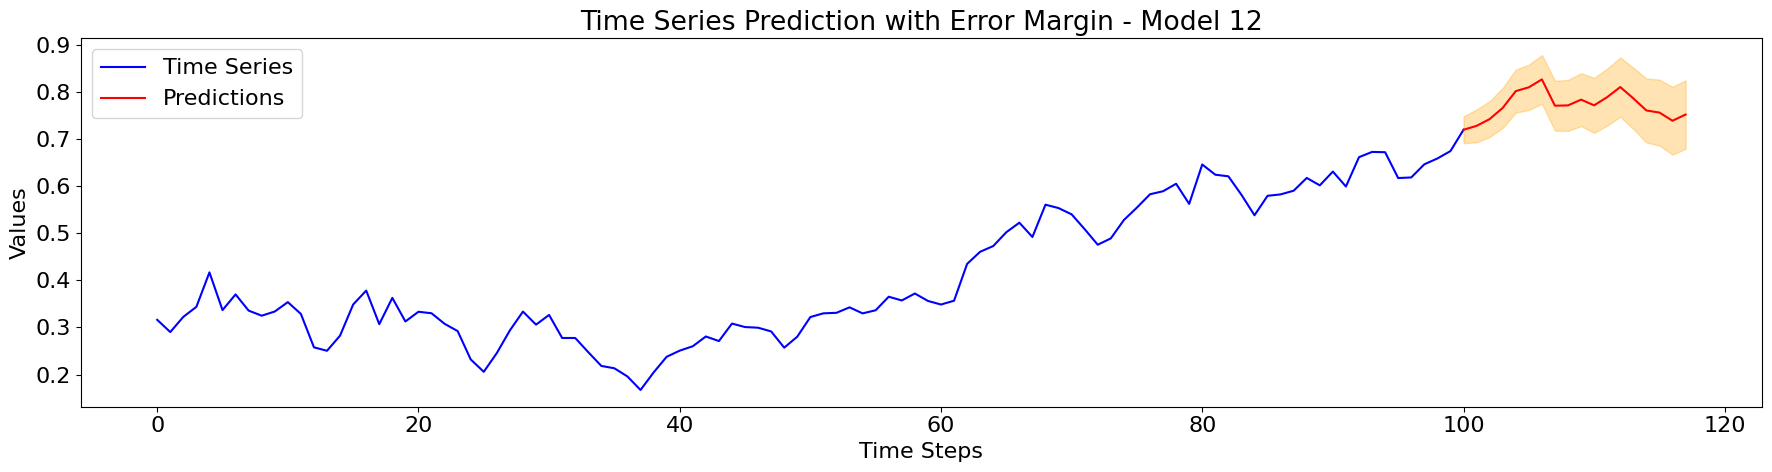

In [137]:
# Assuming X_test and y_test are your test set features and labels
# Replace model1 to model11 with your actual model variables
models = [model]

# Number of models
num_models = len(models)

# Create subplots
fig, axes = plt.subplots(num_models, 1, figsize=(18, num_models * 5))
if num_models == 1:
    axes = [axes]  # Ensure axes is iterable for a single model

# Loop through each model
for i, model in enumerate(models):
    # Calculate Mean Absolute Errors
    future_predictions = model.predict(X_test, verbose=0)
    maes = []
    for idx in range(future_predictions.shape[1]):
        ft_maes = np.mean(np.abs(y_test[:, idx, :] - future_predictions[:, idx, :]), axis=0)
        maes.append(ft_maes)
    maes = np.array(maes)

    # Pad the predictions with NaN to shift them in time
    result = np.concatenate((X_test, future_predictions), axis=1)

    # Create a list from WINDOW_SIZE to the end of the predictions
    idxs = np.arange(WINDOW_SIZE, WINDOW_SIZE + TELESCOPE)

    # Plotting
    axes[i].plot(result[0, :WINDOW_SIZE + 1, 0], color='blue', label='Time Series')
    axes[i].plot(idxs, result[0, :, 0][-TELESCOPE:], color='red', label='Predictions')
    axes[i].fill_between(
        idxs,
        future_predictions[0, :, 0] - maes[:, 0],
        future_predictions[0, :, 0] + maes[:, 0],
        alpha=0.3,
        color='orange',
    )

    axes[i].legend()
    axes[i].set_title(f'Time Series Prediction with Error Margin - Model {12}')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()


In [86]:
import json
import os
import tensorflow as tf

# Assuming models and histories are stored in lists
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12]
histories = [history1, history2, history3, history4, history5, history6, history7, history8, history9, history10, history11]

# Directory to save models and histories
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save each model and its history
for i, (model, history) in enumerate(zip(models, histories), start=1):
    # Save model
    model_path = os.path.join(save_dir, f"model_{i}")
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f"history_{i}.json")
    with open(history_path, 'w') as file:
        json.dump(str(history), file)

print("All models and histories have been saved successfully.")


NameError: ignored